In [1]:
using Falcons
using Healpix
using StatsBase
using PyCall
using Base.Threads
using Statistics
using NPZ
using NaNStatistics
using PyPlot
using LinearAlgebra
using DataFrames

hp = pyimport("healpy")
np = pyimport("numpy")
include("/gpfs/home/cmb/yusuket/program/scan_strategy/optimisation2/functions/spin_characterisation_w_HWP.jl");

T_alpha_min = #= In[74]:10 =# @__dot__(((((2π) * sind(alpha_plus_beta)) / dtheta) / f_hwp) / 60) = 25.04400079001595
T_beta_lim(45, 50, 192.348 * 60, dtheta, f_hwp) / 60 = 22.14087611377642


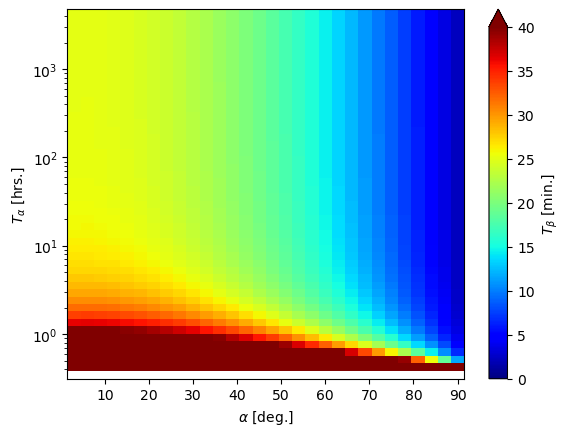

PyObject Text(26.800000000000004, 0.5, '$T_{\\alpha}$ [hrs.]')

In [74]:
step = 3
alpha_plus_beta = 95
alpha = step:step:alpha_plus_beta-step
beta = alpha_plus_beta .- alpha

FWHM = 17.9 / 60
dtheta = deg2rad(FWHM)
f_hwp = 48/60

@show T_alpha_min = @. 2π*sind(alpha_plus_beta)/dtheta/f_hwp/60
@show T_beta_lim(45, 50, 192.348*60, dtheta, f_hwp)/60
#T_alpha = T_alpha_min:10^4 #
T_alpha = logspace(3.1, 7.2, 50)

alpha_grid, T_alpha_grid, T_spin_grid = gen_scan_parameter_space(alpha, T_alpha, FWHM, f_hwp, alpha_plus_beta)
T_spin_grid[T_spin_grid .<0] .= NaN

fig = plt.figure()
ax = fig.add_subplot(111)
P = plt.pcolormesh(alpha_grid, T_alpha_grid/60/60, T_spin_grid/60, cmap="jet",
vmin = 0, vmax = 40)
cbar = plt.colorbar(P, ax=ax, extend="max", label=raw"$T_{\beta}$ [min.]")
ax.set_yscale("log")
ax.set_xlabel(raw"$\alpha$ [deg.]")
ax.set_ylabel(raw"$T_{\alpha}$ [hrs.]")

In [2]:
nside = 256
ss = gen_ScanningStrategy()
ss.nside = nside
ss.sampling_rate = 1.0
ss.FP_theta = [0]
ss.FP_phi = [0]
ss.hwp_rpm = 61
ss.alpha = 3
ss.beta = 95 - ss.alpha
ss.prec_rpm = period2rpm(12260.704, unit="min")
ss.spin_rpm = period2rpm(19.775, unit="min")

#ss.duration = 
Args = Dict(
    "ss" => ss,
    "spin_n" => -5:5 |> collect ,
    "spin_m" => [-8,-4,0,4,8],
    "division" => 6,
    "fwhm" => deg2rad(0.5),
    "rho" => deg2rad(0.1/60),
    "chi" => deg2rad(0),
    "seed" => 1,
    "nreal" => 1,
    "sysfield" => pointing_offset_field,
    "lmax4likelihood" => 3nside-1,
    "sysmap_output" => false
);

In [3]:
field = get_scanfield(ss, division=6, spin_n=Args["spin_n"], spin_m=Args["spin_m"]);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:30


  9.844852 seconds (14.96 M allocations: 2.494 GiB, 5.78% gc time, 40.79% compilation time)


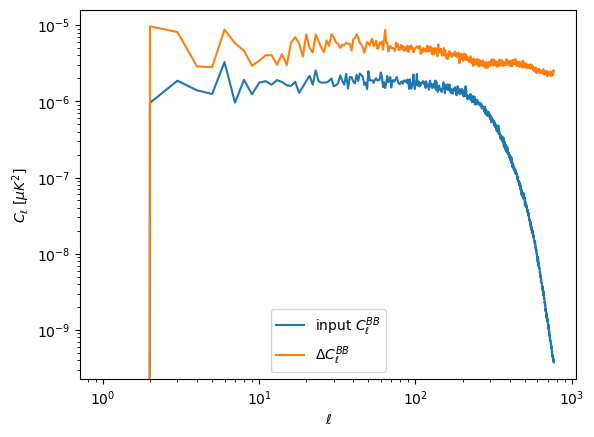

PyObject <matplotlib.legend.Legend object at 0x7fe161faa550>

In [6]:
inputinfo = gen_input(Args);
@time mapbase = pointing_offset_field(field, inputinfo)
resmap = mapbase .- healpy2julia(inputinfo.Inputmap)
incl = hp.anafast(healpy2julia(inputinfo.Inputmap))
rescl = hp.anafast(resmap)
plt.loglog(incl[3,:], label=raw"input $C_\ell^{BB}$")
plt.loglog(rescl[3,:], label=raw"$\Delta C_\ell^{BB}$")
plt.xlabel(raw"$\ell$")
plt.ylabel(raw"$C_\ell$ [$\mu K^2$]")
plt.legend()

In [22]:
rescl[3,:] |> minimum

0.0

In [5]:
#result = estimate_systematics(field, pointing_offset_field, Args, verbose=false);

In [6]:
result = run_systematics(Args);

spin_m => [-8, -4, 0, 4, 8]
lmax4likelihood => 767
sysmap_output => false
fwhm => 0.008726646259971648
chi => 0.0
nreal => 1
spin_n => [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
rho => 2.908882086657216e-5
ss => ScanningStrategy{Float64, Int64, Vector{Float64}, String}(256, 31536000, 1.0, 3.0, 92.0, 8.156138505586629e-5, 0.050568900126422255, 61.0, [0.0], [0.0], "equator", 0.0, "E")
division => 6
seed => 1
sysfield => pointing_offset_field

nside                    : 256 
duration [sec]           : 31536000.0 
sampling rate [Hz]       : 1.0 
alpha [deg]              : 3.0 
beta [deg]               : 92.0 
prec. period [min]       : 12260.704
↳ prec. rate [rpm]       : 0.000082
spin period [min]        : 19.775
↳ spin rate [rpm]        : 0.050569
HWP rot. rate[rpm]       : 61.000000 
start point              : equator 
start angle              : 0.000000 
coordinate system        : E 
FPU                     
↳ Det.1(θ,φ)             : (0.000, 0.000) 


Progress: 100%|█████████████████████████████████████████| Time: 0:01:16


 79.030540 seconds (1.92 G allocations: 57.722 GiB, 20.52% gc time, 0.63% compilation time)
Size of field.h : 0.34603008GB
run `estimate_systematics`
minimum(field.hitmap) = 4
 19.944177 seconds (27.52 M allocations: 5.206 GiB, 3.32% gc time, 43.04% compilation time)
======== Finish ========


In [7]:
create_h5_file("./", 1, "test", result)

In [15]:
data = h5open("./test/output_1.h5")
read(data)["quantify"]["hitmap_std"]

44.41309733363677

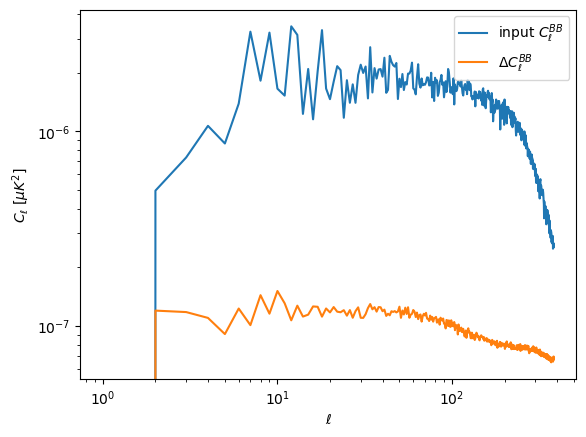

PyObject <matplotlib.legend.Legend object at 0x7f76d9724d60>

In [9]:
plt.loglog(incl[3,:], label=raw"input $C_\ell^{BB}$")
plt.loglog(result.cl_sys[3,:], label=raw"$\Delta C_\ell^{BB}$")

plt.xlabel(raw"$\ell$")
plt.ylabel(raw"$C_\ell$ [$\mu K^2$]")
plt.legend()

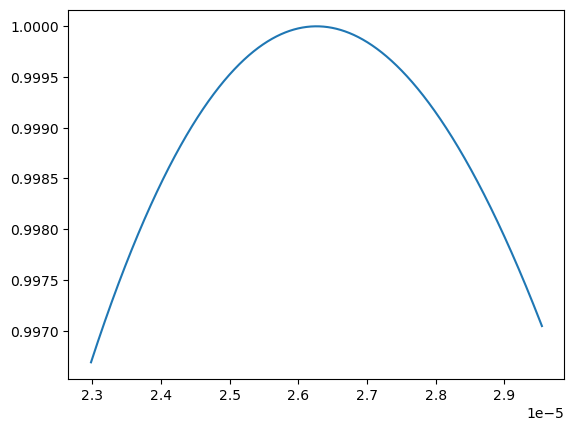

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f76d047b0a0>

In [10]:
plt.plot(result.gridOfr, result.likelihood)

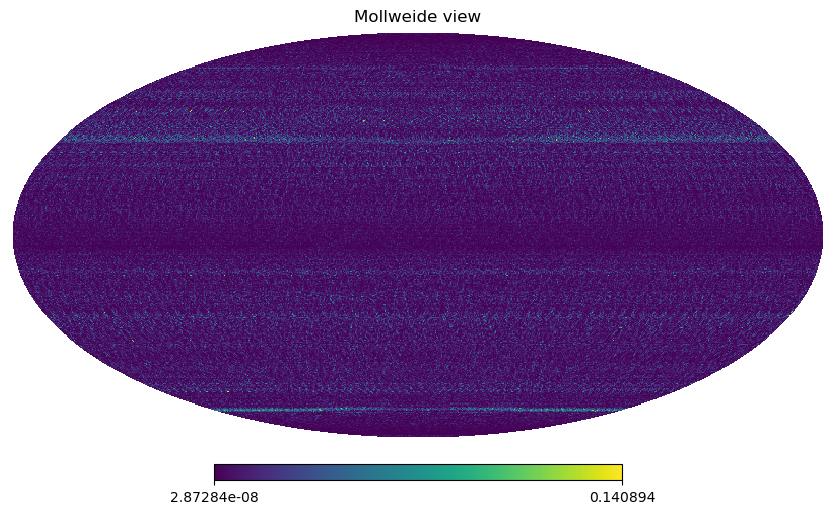

In [12]:
hp.mollview(result.field.h[1,1,:] .|> abs2)

In [81]:
run(`julia ../../systematics/h_nm_and_pointing01.jl`)

spin_m => [-8, -4, 0, 4, 8]
lmax4likelihood => 383
sysmap_output => false
fwhm => 0.008726646259971648
chi => 1.5707963267948966
nreal => 10
spin_n => [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]
rho => 2.908882086657216e-5
ss => ScanningStrategy{Float64, Int64, Vector{Float64}, String}(128, 31536000, 1.0, 45.0, 50.0, 0.005198910308399359, 0.05, 46.0, [0.0], [0.0], "equator", 0.0, "E")
division => 6
seed => 1
sysfield => pointing_offset_field

nside                    : 128 
duration [sec]           : 31536000.0 
sampling rate [Hz]       : 1.0 
alpha [deg]              : 45.0 
beta [deg]               : 50.0 
prec. period [min]       : 192.348
↳ prec. rate [rpm]       : 0.005199
spin period [min]        : 20.000
↳ spin rate [rpm]        : 0.050000
HWP rot. rate[rpm]       : 46.000000 
start point              : equator 
start angle              : 0.000000 
coordinate system        : E 
FPU                     
↳ Det.1(θ,φ)             : (0.000, 0.000) 
run `estimate_systematics`
======== Fin

Progress: 100%|█████████████████████████████████████████| Time: 0:01:33


Process(`julia ../../systematics/h_nm_and_pointing01.jl`, ProcessExited(0))